# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

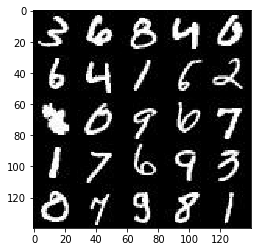

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

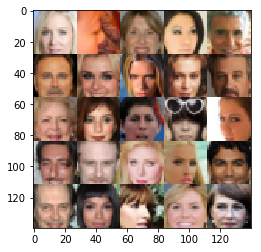

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def lrelu(x, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x)

In [11]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):

        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        #Implementing leaky relu
        relu1 = lrelu(x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = lrelu(bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = lrelu(bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [12]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha=0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = lrelu( x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu( x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = lrelu( x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    steps = 0
    
    data_size, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                #Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                
                #Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4154... Generator Loss: 1.5627
Epoch 1/2... Discriminator Loss: 0.1458... Generator Loss: 2.4795
Epoch 1/2... Discriminator Loss: 3.9540... Generator Loss: 4.9650
Epoch 1/2... Discriminator Loss: 1.4578... Generator Loss: 2.3424
Epoch 1/2... Discriminator Loss: 1.6672... Generator Loss: 0.3570
Epoch 1/2... Discriminator Loss: 0.6033... Generator Loss: 1.0774
Epoch 1/2... Discriminator Loss: 0.6158... Generator Loss: 1.1532
Epoch 1/2... Discriminator Loss: 3.7920... Generator Loss: 0.0332
Epoch 1/2... Discriminator Loss: 1.8535... Generator Loss: 0.2759
Epoch 1/2... Discriminator Loss: 1.6469... Generator Loss: 0.7561


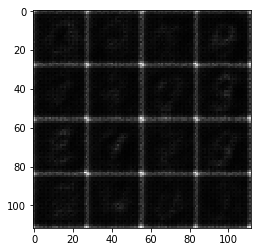

Epoch 1/2... Discriminator Loss: 1.5924... Generator Loss: 1.0310
Epoch 1/2... Discriminator Loss: 1.5837... Generator Loss: 0.6243
Epoch 1/2... Discriminator Loss: 1.4391... Generator Loss: 0.6281
Epoch 1/2... Discriminator Loss: 1.5685... Generator Loss: 0.5289
Epoch 1/2... Discriminator Loss: 1.6176... Generator Loss: 0.9493
Epoch 1/2... Discriminator Loss: 1.4007... Generator Loss: 0.8456
Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.5794... Generator Loss: 0.3086
Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 0.4875
Epoch 1/2... Discriminator Loss: 1.5325... Generator Loss: 0.9754


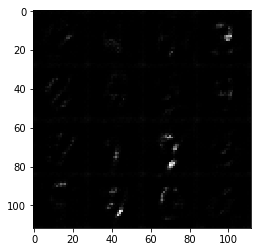

Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 0.7777
Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 1.0573
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 1.1588
Epoch 1/2... Discriminator Loss: 1.5253... Generator Loss: 0.3279
Epoch 1/2... Discriminator Loss: 1.2719... Generator Loss: 0.4500
Epoch 1/2... Discriminator Loss: 1.4651... Generator Loss: 0.3548
Epoch 1/2... Discriminator Loss: 1.3153... Generator Loss: 0.4566
Epoch 1/2... Discriminator Loss: 1.4537... Generator Loss: 0.3484
Epoch 1/2... Discriminator Loss: 1.0151... Generator Loss: 0.8407
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 1.6971


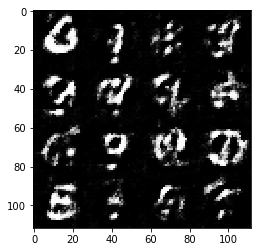

Epoch 1/2... Discriminator Loss: 1.1879... Generator Loss: 0.7344
Epoch 1/2... Discriminator Loss: 1.0864... Generator Loss: 1.1942
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.0701... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 1.7149
Epoch 1/2... Discriminator Loss: 1.1050... Generator Loss: 1.3114
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.6512
Epoch 1/2... Discriminator Loss: 1.1347... Generator Loss: 0.5127
Epoch 1/2... Discriminator Loss: 1.4701... Generator Loss: 0.3234
Epoch 1/2... Discriminator Loss: 1.4658... Generator Loss: 0.3228


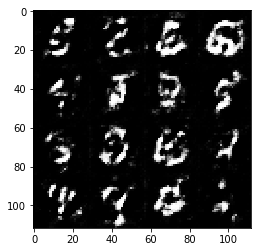

Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 0.5305
Epoch 1/2... Discriminator Loss: 1.2651... Generator Loss: 0.4353
Epoch 1/2... Discriminator Loss: 1.5159... Generator Loss: 0.2999
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 0.6173
Epoch 1/2... Discriminator Loss: 0.8470... Generator Loss: 1.1567
Epoch 1/2... Discriminator Loss: 0.8004... Generator Loss: 1.4871
Epoch 1/2... Discriminator Loss: 0.9941... Generator Loss: 0.7708
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 0.5724
Epoch 1/2... Discriminator Loss: 0.8805... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 0.4670


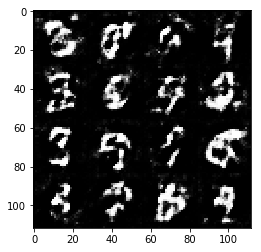

Epoch 1/2... Discriminator Loss: 2.1402... Generator Loss: 0.1491
Epoch 1/2... Discriminator Loss: 0.8472... Generator Loss: 0.8468
Epoch 1/2... Discriminator Loss: 0.7967... Generator Loss: 1.0125
Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 0.9200
Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 1.0758
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 1.4421
Epoch 1/2... Discriminator Loss: 1.7672... Generator Loss: 0.2205
Epoch 1/2... Discriminator Loss: 0.9649... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 0.5814
Epoch 1/2... Discriminator Loss: 1.3016... Generator Loss: 2.1941


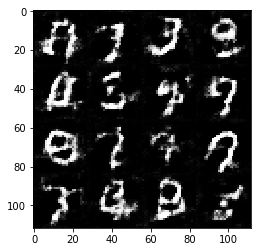

Epoch 1/2... Discriminator Loss: 1.1181... Generator Loss: 0.5125
Epoch 1/2... Discriminator Loss: 0.9207... Generator Loss: 0.8989
Epoch 1/2... Discriminator Loss: 1.8054... Generator Loss: 0.2085
Epoch 1/2... Discriminator Loss: 0.7717... Generator Loss: 0.9898
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 1.5794
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 1.1115
Epoch 1/2... Discriminator Loss: 0.8812... Generator Loss: 1.2427
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 1.9559
Epoch 1/2... Discriminator Loss: 0.9228... Generator Loss: 1.0929
Epoch 1/2... Discriminator Loss: 1.0300... Generator Loss: 1.1768


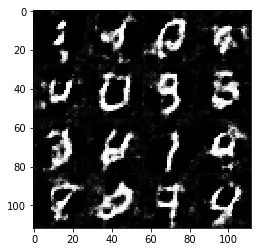

Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.4114
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 0.5127
Epoch 1/2... Discriminator Loss: 1.5645... Generator Loss: 0.3060
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 0.5668
Epoch 1/2... Discriminator Loss: 1.2153... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 1.5275... Generator Loss: 1.7769
Epoch 1/2... Discriminator Loss: 1.3261... Generator Loss: 0.4637
Epoch 1/2... Discriminator Loss: 1.1008... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 1.3669... Generator Loss: 0.3837
Epoch 1/2... Discriminator Loss: 1.4887... Generator Loss: 0.3294


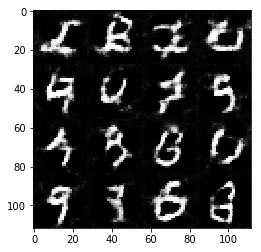

Epoch 1/2... Discriminator Loss: 1.1479... Generator Loss: 0.5214
Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.4116
Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 0.5784
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.3784
Epoch 1/2... Discriminator Loss: 1.5312... Generator Loss: 0.3419
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 0.7984
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 1.3516
Epoch 1/2... Discriminator Loss: 1.1895... Generator Loss: 0.5364
Epoch 1/2... Discriminator Loss: 0.9598... Generator Loss: 0.8812
Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 0.4125


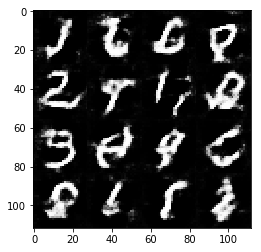

Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 1.2182
Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 0.4196
Epoch 1/2... Discriminator Loss: 1.5682... Generator Loss: 0.3091
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.6225
Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 0.4287
Epoch 1/2... Discriminator Loss: 1.1381... Generator Loss: 0.7192
Epoch 1/2... Discriminator Loss: 0.9349... Generator Loss: 0.7409
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 0.3251
Epoch 1/2... Discriminator Loss: 1.3543... Generator Loss: 0.3876
Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 0.6341


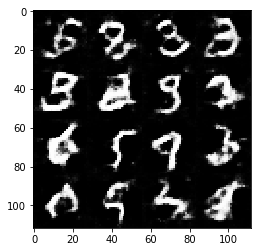

Epoch 1/2... Discriminator Loss: 0.9861... Generator Loss: 0.7364
Epoch 1/2... Discriminator Loss: 1.1538... Generator Loss: 0.4993
Epoch 1/2... Discriminator Loss: 1.4733... Generator Loss: 0.3361
Epoch 1/2... Discriminator Loss: 1.0578... Generator Loss: 0.8884
Epoch 1/2... Discriminator Loss: 1.5909... Generator Loss: 0.2727
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 0.5511
Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 0.3912
Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 0.4960
Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 0.5857
Epoch 1/2... Discriminator Loss: 1.1618... Generator Loss: 1.2580


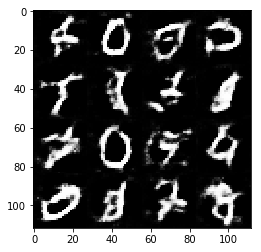

Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 0.5523
Epoch 1/2... Discriminator Loss: 0.9974... Generator Loss: 1.1747
Epoch 1/2... Discriminator Loss: 0.9893... Generator Loss: 1.0021
Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 1.3000
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 0.7067
Epoch 1/2... Discriminator Loss: 1.1379... Generator Loss: 0.5659
Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 0.6008
Epoch 1/2... Discriminator Loss: 0.9776... Generator Loss: 0.7199
Epoch 1/2... Discriminator Loss: 1.0380... Generator Loss: 0.6060
Epoch 1/2... Discriminator Loss: 1.6042... Generator Loss: 0.2720


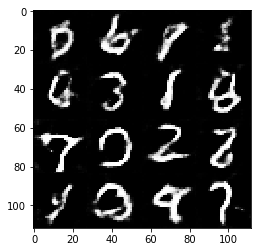

Epoch 1/2... Discriminator Loss: 1.5595... Generator Loss: 0.3032
Epoch 1/2... Discriminator Loss: 0.9744... Generator Loss: 1.0887
Epoch 1/2... Discriminator Loss: 1.3802... Generator Loss: 0.3793
Epoch 1/2... Discriminator Loss: 0.8553... Generator Loss: 1.1045
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 0.5488
Epoch 1/2... Discriminator Loss: 0.9393... Generator Loss: 0.9959
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 0.4215
Epoch 1/2... Discriminator Loss: 0.9397... Generator Loss: 1.0547
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 1.3946
Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 0.7794


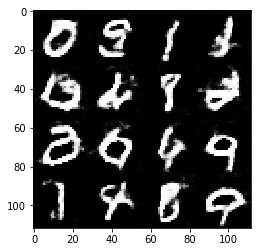

Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 0.5642
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.4374
Epoch 1/2... Discriminator Loss: 1.5450... Generator Loss: 0.3109
Epoch 1/2... Discriminator Loss: 1.0153... Generator Loss: 0.6322
Epoch 1/2... Discriminator Loss: 1.5575... Generator Loss: 0.2898
Epoch 1/2... Discriminator Loss: 1.6790... Generator Loss: 0.2577
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 0.6854
Epoch 1/2... Discriminator Loss: 1.7422... Generator Loss: 0.2276
Epoch 1/2... Discriminator Loss: 0.9118... Generator Loss: 0.9741
Epoch 1/2... Discriminator Loss: 1.0410... Generator Loss: 0.5753


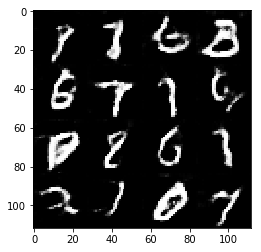

Epoch 1/2... Discriminator Loss: 0.7559... Generator Loss: 1.3144
Epoch 1/2... Discriminator Loss: 2.0609... Generator Loss: 0.1635
Epoch 1/2... Discriminator Loss: 1.6501... Generator Loss: 0.2788
Epoch 1/2... Discriminator Loss: 1.4304... Generator Loss: 0.3704
Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 0.5660
Epoch 1/2... Discriminator Loss: 0.9012... Generator Loss: 1.1352
Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 0.5666
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 0.9965
Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 1.5938... Generator Loss: 0.3026


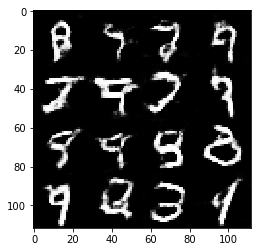

Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 1.0836
Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 0.7641
Epoch 1/2... Discriminator Loss: 1.2119... Generator Loss: 0.4959
Epoch 1/2... Discriminator Loss: 1.7555... Generator Loss: 0.2418
Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 0.5174
Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 0.6965
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.3842
Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 1.1093
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.1278
Epoch 1/2... Discriminator Loss: 1.0957... Generator Loss: 0.6037


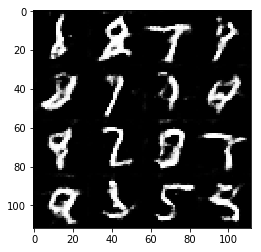

Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 0.7724... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 0.9212... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 0.8936
Epoch 1/2... Discriminator Loss: 1.1194... Generator Loss: 0.5547
Epoch 1/2... Discriminator Loss: 1.9645... Generator Loss: 0.1902
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 0.6461
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 0.7232... Generator Loss: 1.4393
Epoch 1/2... Discriminator Loss: 0.6903... Generator Loss: 1.0117


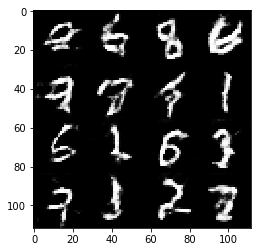

Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 0.5471
Epoch 1/2... Discriminator Loss: 1.2083... Generator Loss: 0.4487
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 0.5225
Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 0.3599
Epoch 1/2... Discriminator Loss: 1.6823... Generator Loss: 0.2498
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 0.7067
Epoch 1/2... Discriminator Loss: 0.9988... Generator Loss: 0.5945
Epoch 1/2... Discriminator Loss: 1.0447... Generator Loss: 0.5731
Epoch 1/2... Discriminator Loss: 1.5182... Generator Loss: 0.3734
Epoch 1/2... Discriminator Loss: 2.6956... Generator Loss: 0.1091


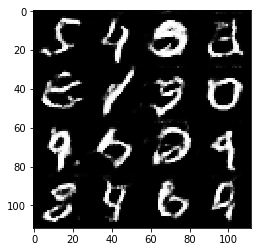

Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 1.2053
Epoch 1/2... Discriminator Loss: 1.2245... Generator Loss: 0.4393
Epoch 1/2... Discriminator Loss: 1.1796... Generator Loss: 0.4792
Epoch 1/2... Discriminator Loss: 0.9209... Generator Loss: 0.7283
Epoch 1/2... Discriminator Loss: 0.6974... Generator Loss: 1.2421
Epoch 1/2... Discriminator Loss: 0.9533... Generator Loss: 0.7137
Epoch 1/2... Discriminator Loss: 2.0766... Generator Loss: 0.1646
Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 0.7793
Epoch 2/2... Discriminator Loss: 0.7949... Generator Loss: 1.0568
Epoch 2/2... Discriminator Loss: 1.0599... Generator Loss: 0.7229


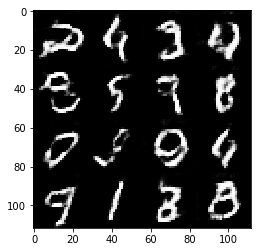

Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 1.0932
Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 0.9840
Epoch 2/2... Discriminator Loss: 1.4553... Generator Loss: 0.3369
Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 0.6928
Epoch 2/2... Discriminator Loss: 0.8389... Generator Loss: 0.7556
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 0.7375
Epoch 2/2... Discriminator Loss: 0.6656... Generator Loss: 1.3150
Epoch 2/2... Discriminator Loss: 0.9300... Generator Loss: 0.6608
Epoch 2/2... Discriminator Loss: 2.9167... Generator Loss: 3.8132
Epoch 2/2... Discriminator Loss: 1.0213... Generator Loss: 0.6911


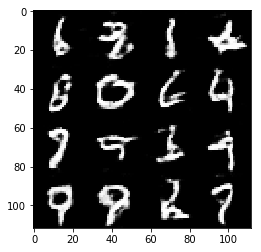

Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 0.7557... Generator Loss: 0.9515
Epoch 2/2... Discriminator Loss: 0.6211... Generator Loss: 1.3101
Epoch 2/2... Discriminator Loss: 1.0170... Generator Loss: 0.6943
Epoch 2/2... Discriminator Loss: 1.3050... Generator Loss: 0.4100
Epoch 2/2... Discriminator Loss: 0.7225... Generator Loss: 1.7828
Epoch 2/2... Discriminator Loss: 0.8227... Generator Loss: 0.9040
Epoch 2/2... Discriminator Loss: 0.7961... Generator Loss: 1.0488
Epoch 2/2... Discriminator Loss: 0.9668... Generator Loss: 0.8367
Epoch 2/2... Discriminator Loss: 0.8925... Generator Loss: 0.7697


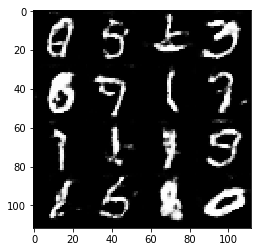

Epoch 2/2... Discriminator Loss: 0.9101... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 0.6687... Generator Loss: 0.9710
Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 1.1446
Epoch 2/2... Discriminator Loss: 3.3670... Generator Loss: 4.5961
Epoch 2/2... Discriminator Loss: 1.1339... Generator Loss: 0.5385
Epoch 2/2... Discriminator Loss: 0.7631... Generator Loss: 0.9934
Epoch 2/2... Discriminator Loss: 0.8418... Generator Loss: 0.7506
Epoch 2/2... Discriminator Loss: 1.9249... Generator Loss: 0.1840
Epoch 2/2... Discriminator Loss: 1.4938... Generator Loss: 0.3275
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 0.8769


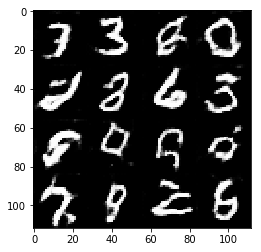

Epoch 2/2... Discriminator Loss: 0.6538... Generator Loss: 1.0713
Epoch 2/2... Discriminator Loss: 1.5456... Generator Loss: 0.3219
Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 2.3373
Epoch 2/2... Discriminator Loss: 0.8917... Generator Loss: 0.7104
Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 0.8209... Generator Loss: 0.7893
Epoch 2/2... Discriminator Loss: 1.9912... Generator Loss: 0.2038
Epoch 2/2... Discriminator Loss: 0.8020... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 0.4672... Generator Loss: 1.7350
Epoch 2/2... Discriminator Loss: 1.1479... Generator Loss: 0.4465


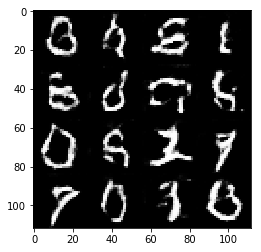

Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.5492
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 0.9176
Epoch 2/2... Discriminator Loss: 1.6617... Generator Loss: 0.2582
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.3672
Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 0.9629
Epoch 2/2... Discriminator Loss: 0.8188... Generator Loss: 0.8257
Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 1.0611
Epoch 2/2... Discriminator Loss: 0.8253... Generator Loss: 0.9878
Epoch 2/2... Discriminator Loss: 0.6775... Generator Loss: 1.3106
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 1.8906


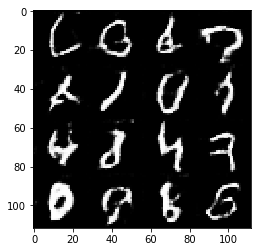

Epoch 2/2... Discriminator Loss: 0.7204... Generator Loss: 1.1808
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 0.8132
Epoch 2/2... Discriminator Loss: 0.5970... Generator Loss: 1.9363
Epoch 2/2... Discriminator Loss: 0.9685... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 0.5901... Generator Loss: 1.4181
Epoch 2/2... Discriminator Loss: 0.7474... Generator Loss: 0.9770
Epoch 2/2... Discriminator Loss: 0.8142... Generator Loss: 0.9102
Epoch 2/2... Discriminator Loss: 0.9215... Generator Loss: 0.6733
Epoch 2/2... Discriminator Loss: 1.7121... Generator Loss: 2.2877
Epoch 2/2... Discriminator Loss: 0.8123... Generator Loss: 1.0020


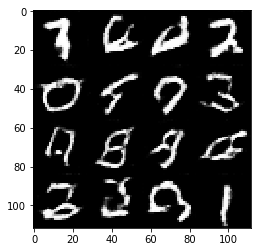

Epoch 2/2... Discriminator Loss: 0.7022... Generator Loss: 0.9266
Epoch 2/2... Discriminator Loss: 1.9543... Generator Loss: 0.2270
Epoch 2/2... Discriminator Loss: 0.8843... Generator Loss: 0.7867
Epoch 2/2... Discriminator Loss: 0.6287... Generator Loss: 1.1926
Epoch 2/2... Discriminator Loss: 0.7218... Generator Loss: 1.3959
Epoch 2/2... Discriminator Loss: 0.6327... Generator Loss: 1.1262
Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 0.9486
Epoch 2/2... Discriminator Loss: 0.8396... Generator Loss: 1.3319
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 1.2883
Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 0.7182


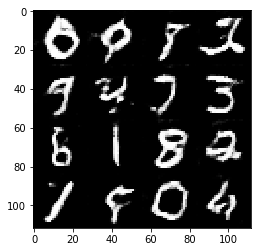

Epoch 2/2... Discriminator Loss: 0.6471... Generator Loss: 1.1722
Epoch 2/2... Discriminator Loss: 0.9776... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 0.4060... Generator Loss: 2.1498
Epoch 2/2... Discriminator Loss: 0.8115... Generator Loss: 0.7908
Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 0.9399
Epoch 2/2... Discriminator Loss: 1.0361... Generator Loss: 0.5613
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.6409
Epoch 2/2... Discriminator Loss: 0.6124... Generator Loss: 1.1556
Epoch 2/2... Discriminator Loss: 0.6729... Generator Loss: 1.1070
Epoch 2/2... Discriminator Loss: 0.6136... Generator Loss: 1.1644


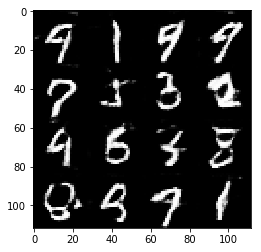

Epoch 2/2... Discriminator Loss: 3.1816... Generator Loss: 0.0922
Epoch 2/2... Discriminator Loss: 1.8889... Generator Loss: 0.2405
Epoch 2/2... Discriminator Loss: 0.9627... Generator Loss: 0.6653
Epoch 2/2... Discriminator Loss: 0.7601... Generator Loss: 1.3766
Epoch 2/2... Discriminator Loss: 0.6381... Generator Loss: 1.4119
Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 0.6201
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 0.7076
Epoch 2/2... Discriminator Loss: 0.6310... Generator Loss: 1.3279
Epoch 2/2... Discriminator Loss: 0.5550... Generator Loss: 1.5510
Epoch 2/2... Discriminator Loss: 0.7192... Generator Loss: 1.3525


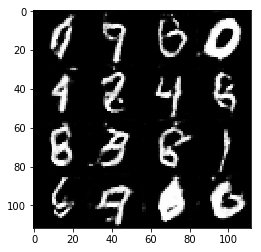

Epoch 2/2... Discriminator Loss: 0.6697... Generator Loss: 1.2402
Epoch 2/2... Discriminator Loss: 1.2974... Generator Loss: 0.4073
Epoch 2/2... Discriminator Loss: 0.6309... Generator Loss: 2.2709
Epoch 2/2... Discriminator Loss: 1.5873... Generator Loss: 2.7438
Epoch 2/2... Discriminator Loss: 0.9444... Generator Loss: 0.6066
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 0.6343
Epoch 2/2... Discriminator Loss: 1.1435... Generator Loss: 0.4950
Epoch 2/2... Discriminator Loss: 0.5415... Generator Loss: 1.2837
Epoch 2/2... Discriminator Loss: 0.7943... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 0.4746... Generator Loss: 2.1800


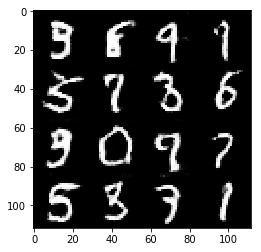

Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 0.4388
Epoch 2/2... Discriminator Loss: 2.7635... Generator Loss: 0.1073
Epoch 2/2... Discriminator Loss: 1.0395... Generator Loss: 0.5464
Epoch 2/2... Discriminator Loss: 0.8804... Generator Loss: 0.7256
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 0.7131
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 0.6189
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 0.6812... Generator Loss: 1.1202
Epoch 2/2... Discriminator Loss: 0.5729... Generator Loss: 1.7441
Epoch 2/2... Discriminator Loss: 0.5900... Generator Loss: 1.5840


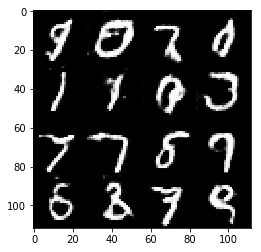

Epoch 2/2... Discriminator Loss: 0.9246... Generator Loss: 0.6992
Epoch 2/2... Discriminator Loss: 0.5878... Generator Loss: 1.0880
Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 1.2296
Epoch 2/2... Discriminator Loss: 0.9644... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 2.0289... Generator Loss: 0.1818
Epoch 2/2... Discriminator Loss: 2.0105... Generator Loss: 0.2161
Epoch 2/2... Discriminator Loss: 0.9897... Generator Loss: 0.6265
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 0.6255
Epoch 2/2... Discriminator Loss: 0.8353... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 0.6012... Generator Loss: 1.0996


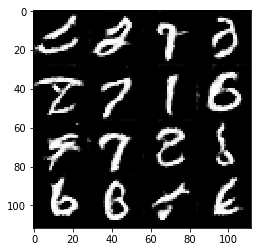

Epoch 2/2... Discriminator Loss: 0.7853... Generator Loss: 0.9735
Epoch 2/2... Discriminator Loss: 0.8179... Generator Loss: 0.8294
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 0.8956
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 1.0791... Generator Loss: 2.5148
Epoch 2/2... Discriminator Loss: 0.9002... Generator Loss: 1.5109
Epoch 2/2... Discriminator Loss: 0.7149... Generator Loss: 1.0378
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 0.7777
Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 0.4910
Epoch 2/2... Discriminator Loss: 0.5574... Generator Loss: 1.1695


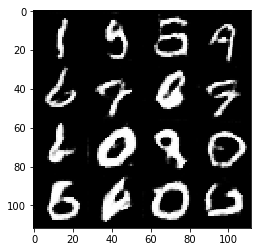

Epoch 2/2... Discriminator Loss: 0.6432... Generator Loss: 1.0546
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 0.7247
Epoch 2/2... Discriminator Loss: 0.6040... Generator Loss: 1.1482
Epoch 2/2... Discriminator Loss: 1.0107... Generator Loss: 0.6505
Epoch 2/2... Discriminator Loss: 0.7713... Generator Loss: 0.9033
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.4353
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 0.5823
Epoch 2/2... Discriminator Loss: 0.5598... Generator Loss: 1.1280
Epoch 2/2... Discriminator Loss: 0.5368... Generator Loss: 1.9143
Epoch 2/2... Discriminator Loss: 0.6925... Generator Loss: 1.0368


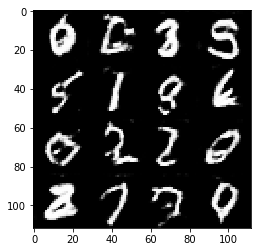

Epoch 2/2... Discriminator Loss: 0.6051... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 0.6640... Generator Loss: 1.1315
Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 0.6549
Epoch 2/2... Discriminator Loss: 0.5408... Generator Loss: 1.5892
Epoch 2/2... Discriminator Loss: 0.5313... Generator Loss: 1.2731
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 0.7800
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 0.5370
Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 0.9075
Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 0.4851
Epoch 2/2... Discriminator Loss: 0.5393... Generator Loss: 1.1935


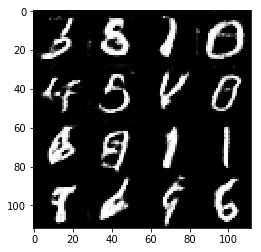

Epoch 2/2... Discriminator Loss: 0.5856... Generator Loss: 1.1239
Epoch 2/2... Discriminator Loss: 0.6215... Generator Loss: 1.2626
Epoch 2/2... Discriminator Loss: 0.4695... Generator Loss: 1.8902
Epoch 2/2... Discriminator Loss: 0.7033... Generator Loss: 0.9410
Epoch 2/2... Discriminator Loss: 0.5510... Generator Loss: 1.3295
Epoch 2/2... Discriminator Loss: 0.9634... Generator Loss: 0.7100
Epoch 2/2... Discriminator Loss: 1.9533... Generator Loss: 2.5612
Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 1.5988
Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 0.5774
Epoch 2/2... Discriminator Loss: 1.2656... Generator Loss: 0.4645


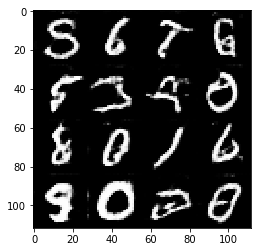

Epoch 2/2... Discriminator Loss: 0.6443... Generator Loss: 1.3502
Epoch 2/2... Discriminator Loss: 0.6185... Generator Loss: 1.0151
Epoch 2/2... Discriminator Loss: 1.0599... Generator Loss: 0.6570
Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 0.8954
Epoch 2/2... Discriminator Loss: 0.7129... Generator Loss: 0.9129
Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.5586
Epoch 2/2... Discriminator Loss: 0.7032... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 0.5535... Generator Loss: 1.8434
Epoch 2/2... Discriminator Loss: 0.6104... Generator Loss: 1.8905
Epoch 2/2... Discriminator Loss: 0.5968... Generator Loss: 1.1850


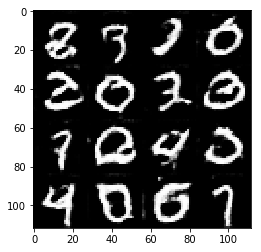

Epoch 2/2... Discriminator Loss: 0.4414... Generator Loss: 1.4337
Epoch 2/2... Discriminator Loss: 0.5463... Generator Loss: 1.2271
Epoch 2/2... Discriminator Loss: 1.0711... Generator Loss: 0.5805
Epoch 2/2... Discriminator Loss: 0.5994... Generator Loss: 1.1427
Epoch 2/2... Discriminator Loss: 0.4831... Generator Loss: 1.2507
Epoch 2/2... Discriminator Loss: 1.6590... Generator Loss: 0.3501
Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 0.9516
Epoch 2/2... Discriminator Loss: 0.6911... Generator Loss: 0.9577
Epoch 2/2... Discriminator Loss: 2.1773... Generator Loss: 0.1862
Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 2.7209


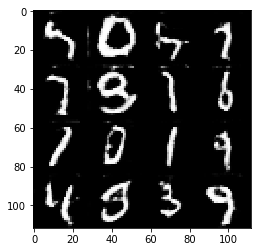

Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 0.7384
Epoch 2/2... Discriminator Loss: 0.6646... Generator Loss: 1.2021
Epoch 2/2... Discriminator Loss: 0.5549... Generator Loss: 1.6170
Epoch 2/2... Discriminator Loss: 1.5571... Generator Loss: 0.2947
Epoch 2/2... Discriminator Loss: 0.4823... Generator Loss: 1.3624


In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.6346... Generator Loss: 0.0448
Epoch 1/1... Discriminator Loss: 2.0621... Generator Loss: 0.1981
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.9218
Epoch 1/1... Discriminator Loss: 0.4732... Generator Loss: 1.7207
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.5933
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 1.4025
Epoch 1/1... Discriminator Loss: 0.6101... Generator Loss: 1.9365
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 0.5629


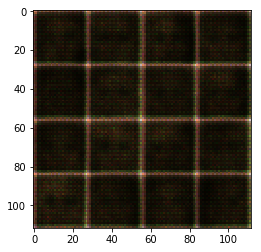

Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 1.3665
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 2.8910... Generator Loss: 0.0629
Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.4513
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 5.0565
Epoch 1/1... Discriminator Loss: 0.5216... Generator Loss: 3.8269
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 2.7404
Epoch 1/1... Discriminator Loss: 0.3542... Generator Loss: 4.0251


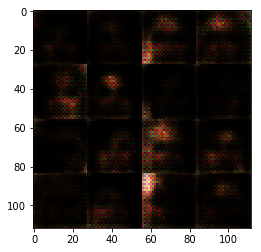

Epoch 1/1... Discriminator Loss: 1.8197... Generator Loss: 3.5809
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 3.3258
Epoch 1/1... Discriminator Loss: 0.4674... Generator Loss: 4.3184
Epoch 1/1... Discriminator Loss: 0.2662... Generator Loss: 2.7828
Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 2.7882
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 3.9725
Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 2.2645
Epoch 1/1... Discriminator Loss: 0.3088... Generator Loss: 2.4163
Epoch 1/1... Discriminator Loss: 0.2307... Generator Loss: 2.7805
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 2.7183


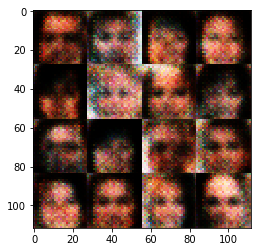

Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 1.7134
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 4.6737
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 2.9317
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 3.5033
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 2.9403
Epoch 1/1... Discriminator Loss: 0.2479... Generator Loss: 2.6201
Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 1.3384
Epoch 1/1... Discriminator Loss: 1.8724... Generator Loss: 2.9718
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 2.9057
Epoch 1/1... Discriminator Loss: 0.6525... Generator Loss: 1.0686


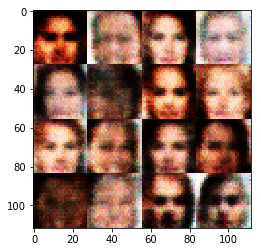

Epoch 1/1... Discriminator Loss: 0.1433... Generator Loss: 3.1517
Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.3694
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 1.2450
Epoch 1/1... Discriminator Loss: 2.3936... Generator Loss: 0.1261
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.3491
Epoch 1/1... Discriminator Loss: 2.4388... Generator Loss: 0.1174
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.7069... Generator Loss: 0.2554


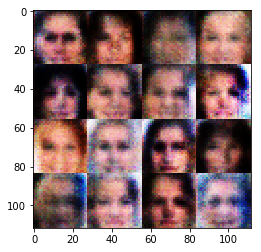

Epoch 1/1... Discriminator Loss: 2.1707... Generator Loss: 0.1851
Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 2.5410
Epoch 1/1... Discriminator Loss: 0.4535... Generator Loss: 2.6921
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 2.7500
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 2.9193
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 3.6202
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 3.0719
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 1.3393
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 3.3083


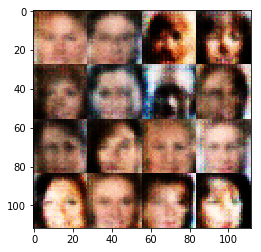

Epoch 1/1... Discriminator Loss: 0.6785... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 2.1386
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 4.2572
Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 1.5198
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.4410
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 3.7852
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 5.0829
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.4524


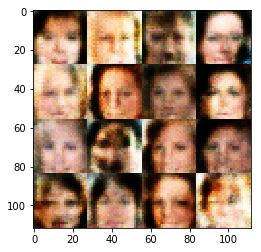

Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 2.7545
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.6885... Generator Loss: 0.2588
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 1.1210
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 5.0603
Epoch 1/1... Discriminator Loss: 0.6399... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 1.6581... Generator Loss: 0.2533
Epoch 1/1... Discriminator Loss: 1.7491... Generator Loss: 0.2594


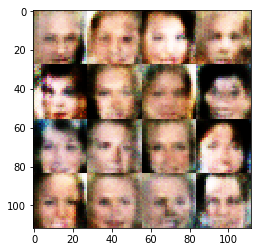

Epoch 1/1... Discriminator Loss: 1.6303... Generator Loss: 0.2838
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 4.4154
Epoch 1/1... Discriminator Loss: 0.2567... Generator Loss: 2.1410
Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 1.1939
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.5999... Generator Loss: 2.0017
Epoch 1/1... Discriminator Loss: 0.2907... Generator Loss: 3.7842
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.3644
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 0.2463... Generator Loss: 2.5772


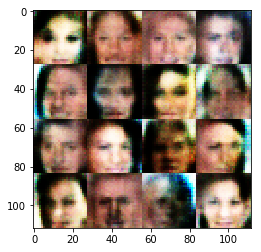

Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 3.2421
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 2.9937
Epoch 1/1... Discriminator Loss: 1.8686... Generator Loss: 0.2136
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.3409
Epoch 1/1... Discriminator Loss: 0.1692... Generator Loss: 3.9259
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 1.7831
Epoch 1/1... Discriminator Loss: 0.1871... Generator Loss: 3.5587
Epoch 1/1... Discriminator Loss: 0.1030... Generator Loss: 3.3237


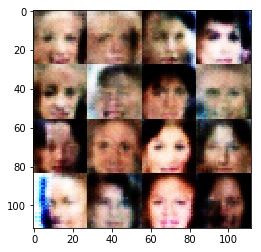

Epoch 1/1... Discriminator Loss: 0.2584... Generator Loss: 5.6010
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 0.2957... Generator Loss: 4.5096
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 4.7734
Epoch 1/1... Discriminator Loss: 0.2301... Generator Loss: 4.1172
Epoch 1/1... Discriminator Loss: 0.3423... Generator Loss: 1.8067
Epoch 1/1... Discriminator Loss: 2.9738... Generator Loss: 0.0595
Epoch 1/1... Discriminator Loss: 0.1165... Generator Loss: 4.7985
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.4743


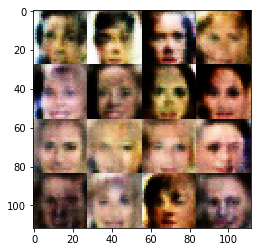

Epoch 1/1... Discriminator Loss: 0.2811... Generator Loss: 2.1247
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.3420
Epoch 1/1... Discriminator Loss: 0.4160... Generator Loss: 3.3813
Epoch 1/1... Discriminator Loss: 0.2846... Generator Loss: 1.9431
Epoch 1/1... Discriminator Loss: 0.7028... Generator Loss: 3.8401
Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 1.7829
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 4.5597
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 1.0900
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 3.8448


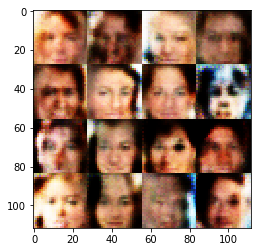

Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.3140
Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 2.1810
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 0.4321... Generator Loss: 1.4326
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 0.1194... Generator Loss: 4.1210
Epoch 1/1... Discriminator Loss: 0.1356... Generator Loss: 3.5867


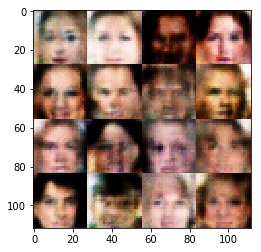

Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 1.3675
Epoch 1/1... Discriminator Loss: 0.2798... Generator Loss: 1.9711
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 1.5362
Epoch 1/1... Discriminator Loss: 0.1469... Generator Loss: 4.0059
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 4.1559
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 1.9150
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 4.7110
Epoch 1/1... Discriminator Loss: 0.1502... Generator Loss: 3.2790
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 1.7345


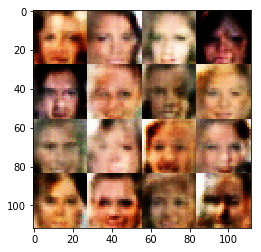

Epoch 1/1... Discriminator Loss: 2.3213... Generator Loss: 3.9581
Epoch 1/1... Discriminator Loss: 0.3135... Generator Loss: 3.0804
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 0.2285... Generator Loss: 2.5308
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 0.6281... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 2.6343
Epoch 1/1... Discriminator Loss: 0.1732... Generator Loss: 3.0356
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 0.9349


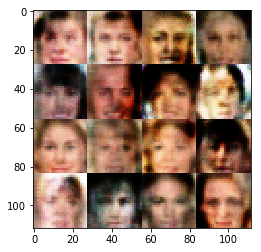

Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 0.1953... Generator Loss: 2.7623
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 1.7538
Epoch 1/1... Discriminator Loss: 1.8285... Generator Loss: 0.2448
Epoch 1/1... Discriminator Loss: 3.5102... Generator Loss: 3.5702
Epoch 1/1... Discriminator Loss: 0.2812... Generator Loss: 4.2723
Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 1.4336
Epoch 1/1... Discriminator Loss: 0.3190... Generator Loss: 3.3924
Epoch 1/1... Discriminator Loss: 0.2127... Generator Loss: 2.2655
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 4.8934


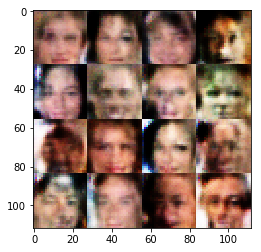

Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 1.4105
Epoch 1/1... Discriminator Loss: 0.2154... Generator Loss: 3.8770
Epoch 1/1... Discriminator Loss: 0.7732... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 0.6731... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 0.2442... Generator Loss: 2.1151
Epoch 1/1... Discriminator Loss: 2.0599... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 0.2770... Generator Loss: 2.1905
Epoch 1/1... Discriminator Loss: 0.2974... Generator Loss: 4.0330
Epoch 1/1... Discriminator Loss: 0.1983... Generator Loss: 2.4787


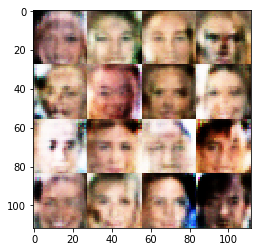

Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.9337... Generator Loss: 0.1835
Epoch 1/1... Discriminator Loss: 0.1875... Generator Loss: 2.6844
Epoch 1/1... Discriminator Loss: 0.4302... Generator Loss: 1.4534
Epoch 1/1... Discriminator Loss: 0.1154... Generator Loss: 3.7318
Epoch 1/1... Discriminator Loss: 0.1959... Generator Loss: 3.4328
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 3.2554
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.1933
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 0.2699... Generator Loss: 2.3698


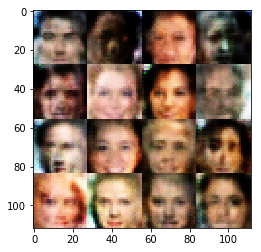

Epoch 1/1... Discriminator Loss: 0.5502... Generator Loss: 1.4990
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 1.9720
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.3953
Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 1.9688
Epoch 1/1... Discriminator Loss: 0.4566... Generator Loss: 1.3968
Epoch 1/1... Discriminator Loss: 1.7181... Generator Loss: 4.5764
Epoch 1/1... Discriminator Loss: 0.2650... Generator Loss: 2.0432
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.3433
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.3137


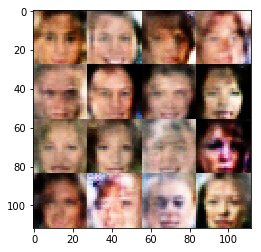

Epoch 1/1... Discriminator Loss: 0.1988... Generator Loss: 2.3793
Epoch 1/1... Discriminator Loss: 0.2003... Generator Loss: 2.5165
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 1.7066... Generator Loss: 0.2536
Epoch 1/1... Discriminator Loss: 0.2131... Generator Loss: 2.7810
Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 3.8077
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.4650
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 0.8399


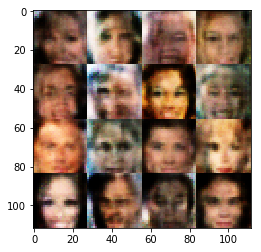

Epoch 1/1... Discriminator Loss: 0.3532... Generator Loss: 1.6337
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 1.4497
Epoch 1/1... Discriminator Loss: 0.3802... Generator Loss: 2.5491
Epoch 1/1... Discriminator Loss: 0.2409... Generator Loss: 3.9887
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 1.7005
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.3835
Epoch 1/1... Discriminator Loss: 0.2732... Generator Loss: 2.1398
Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 1.7708
Epoch 1/1... Discriminator Loss: 0.2756... Generator Loss: 1.8830
Epoch 1/1... Discriminator Loss: 0.1698... Generator Loss: 3.6567


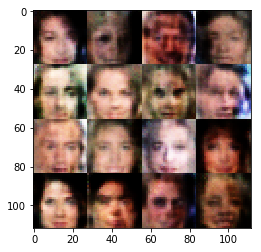

Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 2.1969
Epoch 1/1... Discriminator Loss: 0.2677... Generator Loss: 1.9871
Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 2.1119
Epoch 1/1... Discriminator Loss: 0.1705... Generator Loss: 3.4034
Epoch 1/1... Discriminator Loss: 0.4130... Generator Loss: 3.9404
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 1.5455
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.0649
Epoch 1/1... Discriminator Loss: 0.5653... Generator Loss: 4.4320
Epoch 1/1... Discriminator Loss: 0.6242... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.6054


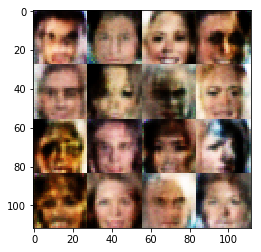

Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.9187
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 1.9041
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 2.5954
Epoch 1/1... Discriminator Loss: 0.5882... Generator Loss: 1.5769
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 1.2961
Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 1.6725
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 2.6243
Epoch 1/1... Discriminator Loss: 0.1533... Generator Loss: 2.6200
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 2.9397


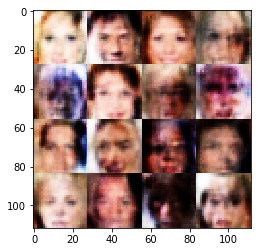

Epoch 1/1... Discriminator Loss: 0.2468... Generator Loss: 2.1354
Epoch 1/1... Discriminator Loss: 0.1236... Generator Loss: 3.2057
Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 1.5435
Epoch 1/1... Discriminator Loss: 2.1025... Generator Loss: 4.7956
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 1.9392
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 0.1319... Generator Loss: 3.3935
Epoch 1/1... Discriminator Loss: 0.3305... Generator Loss: 2.1764
Epoch 1/1... Discriminator Loss: 0.1266... Generator Loss: 2.6436
Epoch 1/1... Discriminator Loss: 0.5530... Generator Loss: 1.8408


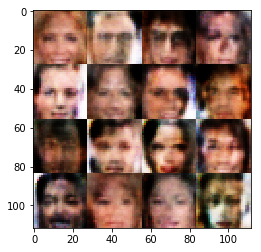

Epoch 1/1... Discriminator Loss: 2.3028... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 0.2673... Generator Loss: 2.7031
Epoch 1/1... Discriminator Loss: 0.3756... Generator Loss: 3.8207
Epoch 1/1... Discriminator Loss: 0.1484... Generator Loss: 3.5177
Epoch 1/1... Discriminator Loss: 0.1347... Generator Loss: 3.2505
Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 1.2345
Epoch 1/1... Discriminator Loss: 0.6936... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 2.1706... Generator Loss: 2.1776
Epoch 1/1... Discriminator Loss: 0.3118... Generator Loss: 1.9086
Epoch 1/1... Discriminator Loss: 0.2057... Generator Loss: 5.3258


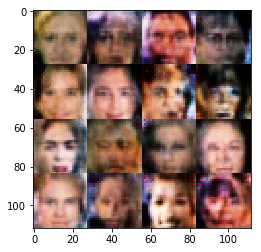

Epoch 1/1... Discriminator Loss: 0.4731... Generator Loss: 2.2775
Epoch 1/1... Discriminator Loss: 3.6593... Generator Loss: 4.3987
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 0.1807... Generator Loss: 3.7321
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 1.5697
Epoch 1/1... Discriminator Loss: 0.2825... Generator Loss: 2.1014
Epoch 1/1... Discriminator Loss: 0.2779... Generator Loss: 1.8051
Epoch 1/1... Discriminator Loss: 0.0993... Generator Loss: 4.3561
Epoch 1/1... Discriminator Loss: 0.1308... Generator Loss: 3.4525


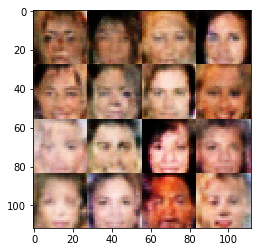

Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.3476
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 1.6133
Epoch 1/1... Discriminator Loss: 0.1069... Generator Loss: 4.0469
Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 0.2582... Generator Loss: 2.8770
Epoch 1/1... Discriminator Loss: 0.1815... Generator Loss: 4.2606
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 0.1542... Generator Loss: 2.9009
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 2.5196
Epoch 1/1... Discriminator Loss: 0.0935... Generator Loss: 3.2376


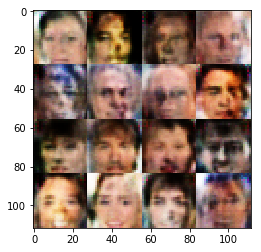

Epoch 1/1... Discriminator Loss: 0.2437... Generator Loss: 3.7601
Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 2.8372
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 2.7534
Epoch 1/1... Discriminator Loss: 0.2753... Generator Loss: 2.0122
Epoch 1/1... Discriminator Loss: 0.3185... Generator Loss: 1.7763
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 1.6911
Epoch 1/1... Discriminator Loss: 0.3325... Generator Loss: 2.7599


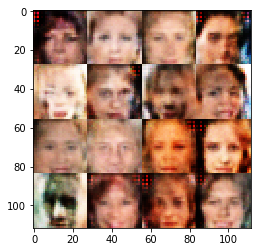

Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 1.3009
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 3.1206
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 4.3285
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 1.1482
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 0.2319... Generator Loss: 2.2596
Epoch 1/1... Discriminator Loss: 0.2565... Generator Loss: 2.7846
Epoch 1/1... Discriminator Loss: 0.2644... Generator Loss: 2.4695


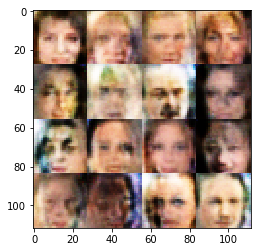

Epoch 1/1... Discriminator Loss: 0.6345... Generator Loss: 2.0801
Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 1.9782... Generator Loss: 0.1845
Epoch 1/1... Discriminator Loss: 0.3256... Generator Loss: 1.9856
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 0.1798... Generator Loss: 2.5811
Epoch 1/1... Discriminator Loss: 0.2034... Generator Loss: 2.9674
Epoch 1/1... Discriminator Loss: 0.1073... Generator Loss: 3.7005
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 0.7746


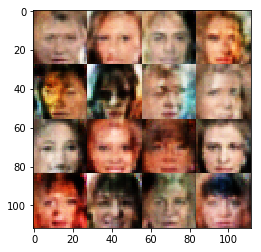

Epoch 1/1... Discriminator Loss: 2.3161... Generator Loss: 2.7268
Epoch 1/1... Discriminator Loss: 0.5346... Generator Loss: 1.1983
Epoch 1/1... Discriminator Loss: 0.2701... Generator Loss: 1.9633
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 1.6796
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 0.3519... Generator Loss: 3.9312
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 2.2994
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 0.8338


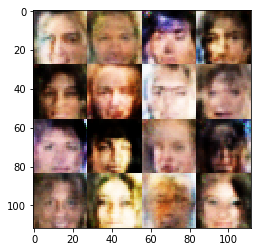

Epoch 1/1... Discriminator Loss: 0.1349... Generator Loss: 3.2311
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 0.1659... Generator Loss: 2.7408
Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 1.6109
Epoch 1/1... Discriminator Loss: 0.1755... Generator Loss: 2.7321
Epoch 1/1... Discriminator Loss: 0.2736... Generator Loss: 1.9917
Epoch 1/1... Discriminator Loss: 0.5535... Generator Loss: 1.2541
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.3018
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.1419


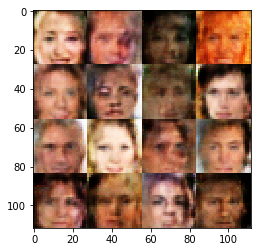

Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 0.6692... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.2940
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 1.6054
Epoch 1/1... Discriminator Loss: 0.3241... Generator Loss: 2.5313
Epoch 1/1... Discriminator Loss: 0.3049... Generator Loss: 3.3954
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 2.4370
Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 1.7641
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 0.6626


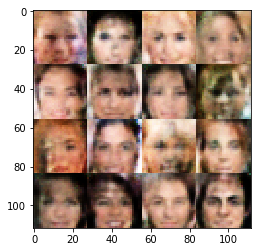

Epoch 1/1... Discriminator Loss: 0.0538... Generator Loss: 5.1836
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 1.4380
Epoch 1/1... Discriminator Loss: 1.7412... Generator Loss: 0.2627
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 0.1796... Generator Loss: 4.0374
Epoch 1/1... Discriminator Loss: 0.0511... Generator Loss: 5.2027
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 0.2323... Generator Loss: 4.2968
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.7056


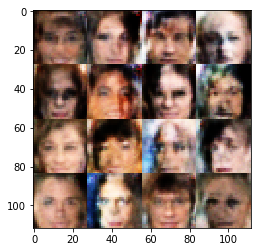

Epoch 1/1... Discriminator Loss: 0.1733... Generator Loss: 3.5213
Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.4449
Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 0.1526... Generator Loss: 2.9792
Epoch 1/1... Discriminator Loss: 0.3568... Generator Loss: 1.5357
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.1054
Epoch 1/1... Discriminator Loss: 0.0997... Generator Loss: 4.2150
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 1.3872


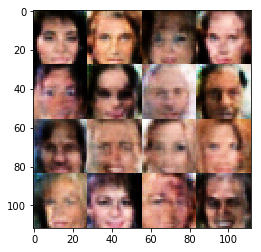

Epoch 1/1... Discriminator Loss: 1.6596... Generator Loss: 0.2756
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 0.2996... Generator Loss: 2.1331
Epoch 1/1... Discriminator Loss: 0.3238... Generator Loss: 1.8906
Epoch 1/1... Discriminator Loss: 1.9796... Generator Loss: 5.4450
Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 1.9925
Epoch 1/1... Discriminator Loss: 0.2003... Generator Loss: 2.3797
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 1.3045
Epoch 1/1... Discriminator Loss: 0.4760... Generator Loss: 2.6758
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 4.0683


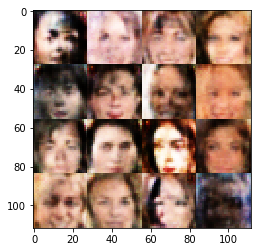

Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 4.9921
Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 2.1018
Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 0.3316... Generator Loss: 1.9864
Epoch 1/1... Discriminator Loss: 0.2755... Generator Loss: 2.7204
Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 3.8251
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.3303
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.4818


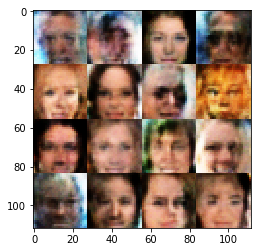

Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 0.1965... Generator Loss: 3.2826
Epoch 1/1... Discriminator Loss: 2.3159... Generator Loss: 0.1699
Epoch 1/1... Discriminator Loss: 0.5767... Generator Loss: 1.3747
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 2.3188
Epoch 1/1... Discriminator Loss: 0.3011... Generator Loss: 1.8767
Epoch 1/1... Discriminator Loss: 0.2208... Generator Loss: 4.0959
Epoch 1/1... Discriminator Loss: 0.1110... Generator Loss: 3.2734


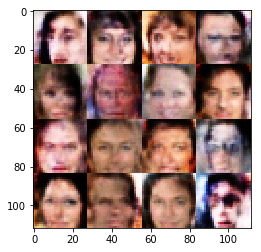

Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.0973
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 1.3121
Epoch 1/1... Discriminator Loss: 0.1924... Generator Loss: 2.4475
Epoch 1/1... Discriminator Loss: 0.1585... Generator Loss: 3.8004
Epoch 1/1... Discriminator Loss: 0.1302... Generator Loss: 2.8269
Epoch 1/1... Discriminator Loss: 0.3029... Generator Loss: 1.8424
Epoch 1/1... Discriminator Loss: 0.3396... Generator Loss: 1.7463
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 0.1873... Generator Loss: 2.2417
Epoch 1/1... Discriminator Loss: 0.1700... Generator Loss: 3.1600


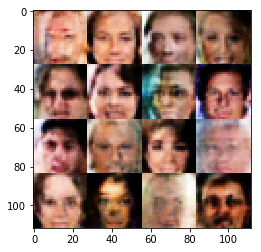

Epoch 1/1... Discriminator Loss: 0.1149... Generator Loss: 5.0732
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 2.2402
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 1.4751
Epoch 1/1... Discriminator Loss: 0.2245... Generator Loss: 2.3502
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 2.4442
Epoch 1/1... Discriminator Loss: 0.4415... Generator Loss: 1.7389
Epoch 1/1... Discriminator Loss: 0.6825... Generator Loss: 1.3923
Epoch 1/1... Discriminator Loss: 0.1777... Generator Loss: 3.4503


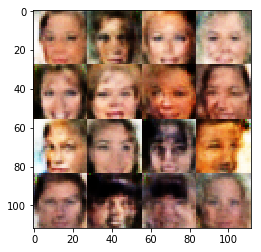

Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 1.8301
Epoch 1/1... Discriminator Loss: 2.5918... Generator Loss: 3.1974
Epoch 1/1... Discriminator Loss: 0.2313... Generator Loss: 2.1644
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 0.2938... Generator Loss: 2.9351
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 1.5472
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.4838
Epoch 1/1... Discriminator Loss: 0.1740... Generator Loss: 2.8147


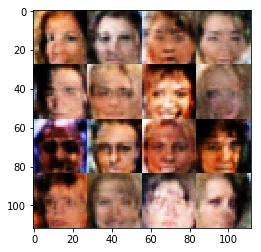

Epoch 1/1... Discriminator Loss: 0.3160... Generator Loss: 3.8672
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 1.4578
Epoch 1/1... Discriminator Loss: 0.2380... Generator Loss: 2.2497
Epoch 1/1... Discriminator Loss: 0.1154... Generator Loss: 3.7260
Epoch 1/1... Discriminator Loss: 0.4010... Generator Loss: 1.6613
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 1.4863
Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 2.0031
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.3456


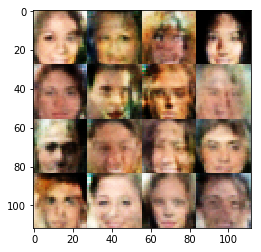

Epoch 1/1... Discriminator Loss: 0.2883... Generator Loss: 1.7518
Epoch 1/1... Discriminator Loss: 0.4441... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 0.2919... Generator Loss: 1.8988
Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 1.5238
Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 3.0274
Epoch 1/1... Discriminator Loss: 0.1405... Generator Loss: 2.7077
Epoch 1/1... Discriminator Loss: 0.5953... Generator Loss: 2.0122
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 0.7843


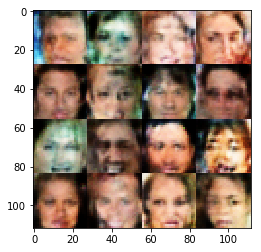

Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 2.9709
Epoch 1/1... Discriminator Loss: 0.1194... Generator Loss: 4.6432
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.5190
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 1.2336
Epoch 1/1... Discriminator Loss: 0.1946... Generator Loss: 2.5441
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 1.6603
Epoch 1/1... Discriminator Loss: 0.1689... Generator Loss: 2.5378


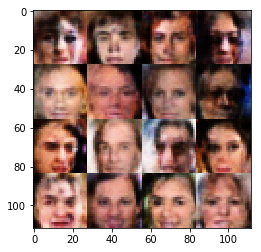

Epoch 1/1... Discriminator Loss: 0.2975... Generator Loss: 2.0462
Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 2.4648
Epoch 1/1... Discriminator Loss: 0.5445... Generator Loss: 3.8375
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 2.2892
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 1.6558... Generator Loss: 0.2708
Epoch 1/1... Discriminator Loss: 0.4046... Generator Loss: 1.7850


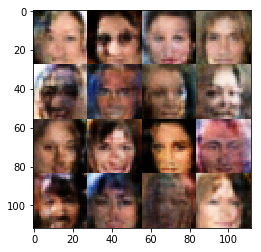

Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 0.3476... Generator Loss: 2.8529
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 1.7254
Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 3.2677
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 1.5655
Epoch 1/1... Discriminator Loss: 0.2283... Generator Loss: 3.4325
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 1.3882
Epoch 1/1... Discriminator Loss: 0.5414... Generator Loss: 1.0751


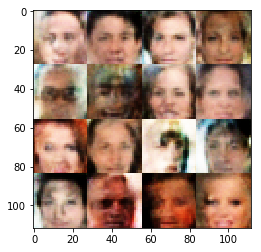

Epoch 1/1... Discriminator Loss: 0.0946... Generator Loss: 6.0860
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.5752
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 2.1034
Epoch 1/1... Discriminator Loss: 0.5687... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 0.3083... Generator Loss: 3.1776
Epoch 1/1... Discriminator Loss: 0.1267... Generator Loss: 3.4243
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 0.4017... Generator Loss: 1.6933
Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 1.3483


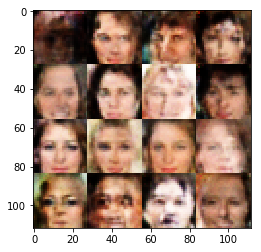

Epoch 1/1... Discriminator Loss: 0.4835... Generator Loss: 1.3932
Epoch 1/1... Discriminator Loss: 1.8227... Generator Loss: 0.2345
Epoch 1/1... Discriminator Loss: 0.0933... Generator Loss: 5.7235
Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 2.9476
Epoch 1/1... Discriminator Loss: 0.2649... Generator Loss: 1.9507
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.4479
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 4.7145
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 0.3236... Generator Loss: 1.7435


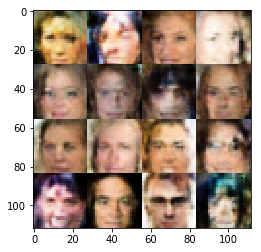

Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 0.2791... Generator Loss: 1.8555
Epoch 1/1... Discriminator Loss: 0.1164... Generator Loss: 3.2083
Epoch 1/1... Discriminator Loss: 2.3637... Generator Loss: 2.9159
Epoch 1/1... Discriminator Loss: 0.1523... Generator Loss: 4.6572
Epoch 1/1... Discriminator Loss: 0.2892... Generator Loss: 4.4762
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 1.6965
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 1.8341


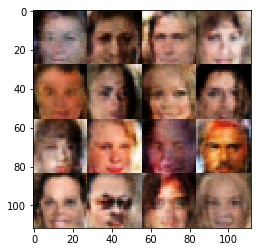

Epoch 1/1... Discriminator Loss: 0.3629... Generator Loss: 1.9598
Epoch 1/1... Discriminator Loss: 0.5260... Generator Loss: 2.7723
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 1.7331
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.4357
Epoch 1/1... Discriminator Loss: 0.1281... Generator Loss: 3.1954
Epoch 1/1... Discriminator Loss: 0.1678... Generator Loss: 3.1636
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 0.1795... Generator Loss: 3.5070
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 2.3936


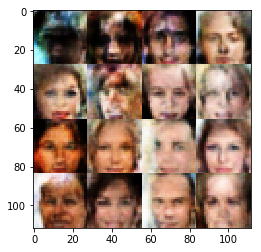

Epoch 1/1... Discriminator Loss: 0.4635... Generator Loss: 1.3326
Epoch 1/1... Discriminator Loss: 0.3043... Generator Loss: 1.6948
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 1.8159
Epoch 1/1... Discriminator Loss: 0.2872... Generator Loss: 1.8794
Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 1.2565
Epoch 1/1... Discriminator Loss: 0.2481... Generator Loss: 1.9904
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.1817
Epoch 1/1... Discriminator Loss: 0.3767... Generator Loss: 2.7126
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.4993


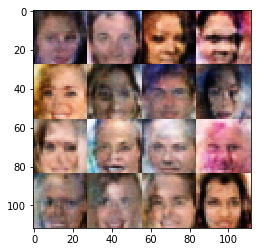

Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.5537
Epoch 1/1... Discriminator Loss: 0.0819... Generator Loss: 3.6376
Epoch 1/1... Discriminator Loss: 0.1672... Generator Loss: 5.5487
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 1.3890
Epoch 1/1... Discriminator Loss: 0.1146... Generator Loss: 3.8444
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 0.2940... Generator Loss: 2.0337
Epoch 1/1... Discriminator Loss: 0.2024... Generator Loss: 2.3537
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.4308
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 1.5540


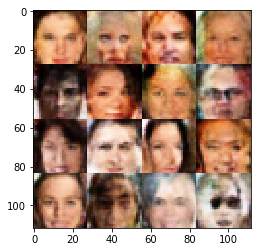

Epoch 1/1... Discriminator Loss: 0.2278... Generator Loss: 2.1537
Epoch 1/1... Discriminator Loss: 0.2440... Generator Loss: 2.9124
Epoch 1/1... Discriminator Loss: 0.7478... Generator Loss: 1.5014
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 2.8609
Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 1.6831
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.4185
Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 1.1945
Epoch 1/1... Discriminator Loss: 0.4448... Generator Loss: 2.3280
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.3083


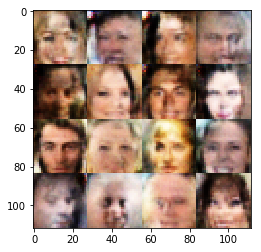

Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 0.4163... Generator Loss: 1.4323
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 0.8389... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 0.1869... Generator Loss: 2.5620
Epoch 1/1... Discriminator Loss: 0.2130... Generator Loss: 3.4255
Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 2.5319
Epoch 1/1... Discriminator Loss: 0.1763... Generator Loss: 2.8740
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.4508


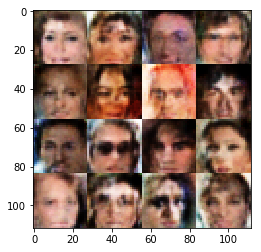

Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.3478
Epoch 1/1... Discriminator Loss: 0.1866... Generator Loss: 3.3026
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 1.5912
Epoch 1/1... Discriminator Loss: 0.2176... Generator Loss: 3.7639
Epoch 1/1... Discriminator Loss: 1.7310... Generator Loss: 0.2595
Epoch 1/1... Discriminator Loss: 0.2418... Generator Loss: 3.3434
Epoch 1/1... Discriminator Loss: 0.2605... Generator Loss: 2.1999
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 2.6659
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 3.5522


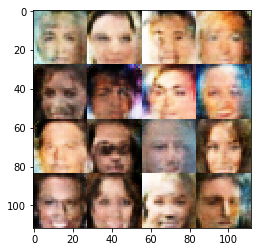

Epoch 1/1... Discriminator Loss: 0.2803... Generator Loss: 2.0303
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 0.3213... Generator Loss: 1.7669
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 0.0734... Generator Loss: 4.5912
Epoch 1/1... Discriminator Loss: 1.6803... Generator Loss: 0.2553
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.9315... Generator Loss: 0.1978
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.6851


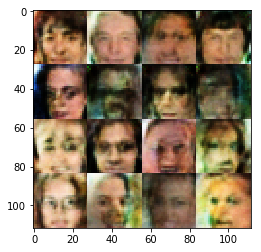

Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 2.9998
Epoch 1/1... Discriminator Loss: 1.9769... Generator Loss: 2.4756
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 0.2386... Generator Loss: 2.9867
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 0.1053... Generator Loss: 3.6269
Epoch 1/1... Discriminator Loss: 0.4871... Generator Loss: 1.3716
Epoch 1/1... Discriminator Loss: 0.1600... Generator Loss: 3.3748
Epoch 1/1... Discriminator Loss: 0.1007... Generator Loss: 4.5702
Epoch 1/1... Discriminator Loss: 0.1467... Generator Loss: 4.2652


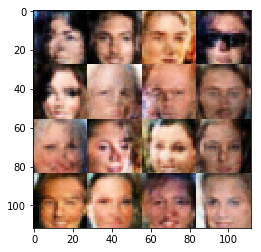

Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 1.8273
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 1.8806
Epoch 1/1... Discriminator Loss: 0.1370... Generator Loss: 3.5820
Epoch 1/1... Discriminator Loss: 0.5205... Generator Loss: 1.5868
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 2.6316
Epoch 1/1... Discriminator Loss: 0.4984... Generator Loss: 2.6975
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 0.2628... Generator Loss: 2.6995
Epoch 1/1... Discriminator Loss: 0.2831... Generator Loss: 1.8969


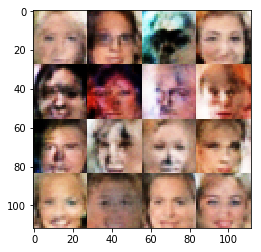

Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 1.8435
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 4.8325
Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 2.0407
Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 1.5790
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 0.2564... Generator Loss: 3.8015
Epoch 1/1... Discriminator Loss: 0.2790... Generator Loss: 1.8998
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.6992


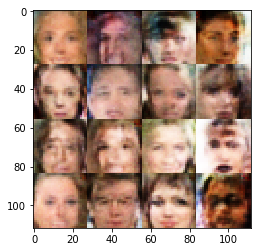

Epoch 1/1... Discriminator Loss: 2.2021... Generator Loss: 0.1632
Epoch 1/1... Discriminator Loss: 0.3542... Generator Loss: 2.1237
Epoch 1/1... Discriminator Loss: 0.2791... Generator Loss: 2.4278
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 0.2364... Generator Loss: 2.3493
Epoch 1/1... Discriminator Loss: 0.7745... Generator Loss: 1.3505
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.4986
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 1.7195
Epoch 1/1... Discriminator Loss: 0.1612... Generator Loss: 3.7256


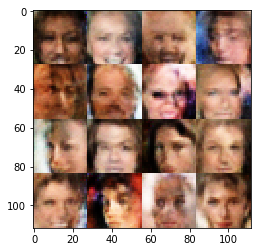

Epoch 1/1... Discriminator Loss: 2.2665... Generator Loss: 2.5032
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 3.4790
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 0.1915... Generator Loss: 2.6545
Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.6304... Generator Loss: 0.2950
Epoch 1/1... Discriminator Loss: 0.1190... Generator Loss: 2.8671
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 0.4417... Generator Loss: 2.1797


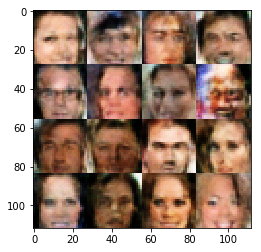

Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.7463
Epoch 1/1... Discriminator Loss: 0.3038... Generator Loss: 3.1453
Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 1.8078
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 2.1383
Epoch 1/1... Discriminator Loss: 0.2879... Generator Loss: 2.4535
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 6.5666


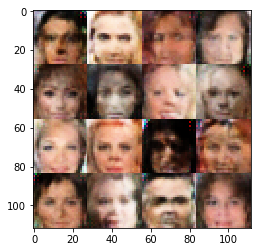

Epoch 1/1... Discriminator Loss: 1.6755... Generator Loss: 2.7552
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 0.4713... Generator Loss: 1.4136
Epoch 1/1... Discriminator Loss: 0.1396... Generator Loss: 4.2085
Epoch 1/1... Discriminator Loss: 0.1496... Generator Loss: 2.7912
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.4565
Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 1.4584
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 1.7323
Epoch 1/1... Discriminator Loss: 0.1386... Generator Loss: 3.2754


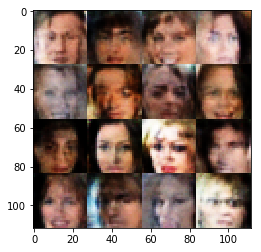

Epoch 1/1... Discriminator Loss: 0.5316... Generator Loss: 1.3764
Epoch 1/1... Discriminator Loss: 0.1331... Generator Loss: 4.6737
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.4252


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.